In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#store the path of the drug-metabolite file
path = 'C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\Datasets\\citrinin_integrated.csv'

In [4]:
#extract the name of the drug

dr = path.split('\\')[-1]
drug_name = dr.split('_')[0]
drug_name

'citrinin'

In [5]:
#read the input drug-metabolite integrated data
data = pd.read_csv(path)

In [6]:
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,1.93205,3.74886,0.452336,0.940899,2.78817,0.493042,1.21729,36.0483,2.49718,2.30652
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,1.96807,3.22352,0.157620,0.343406,2.11181,0.135277,1.42039,103.5290,1.27063,1.64715


In [7]:
#drop the target drug column
drug = data.pop(f'{drug_name}')

In [8]:
#read the representative set of metabolites

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [9]:
#read the representative set of metabolites

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [10]:
len(rep_meta), len(rep_genes)

(197, 24023)

In [11]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites and the gene expression profiles
X = X[rep_genes]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [12]:
X.shape

(52, 24023)

In [13]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [14]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [15]:
X.shape, y.shape

((52, 24023), (52,))

In [16]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

0    35
1    17
dtype: int64

In [17]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [18]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.252086,1.037334,-0.004297,0.032270,-0.014117,0.019787,0.060087,-0.104252,2.403968,0.071395,...,-1.091052,-0.981083,-0.394950,-1.187590,0.907110,-1.107392,-0.322921,0.338147,-0.650807,0.946799
1,1.949560,0.208509,-0.239529,-0.235953,-0.014117,-0.210482,0.060087,-0.104252,-1.021326,5.042785,...,-0.682554,-0.095040,-1.151304,0.019664,-0.929615,-0.960551,-1.033955,-2.165956,-1.575279,0.576646


In [19]:
X.shape, y.shape

((70, 24023), (70,))

In [20]:
y.value_counts()

1    35
0    35
dtype: int64

In [21]:
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.252086,1.037334,-0.004297,0.032270,-0.014117,0.019787,0.060087,-0.104252,2.403968,0.071395,...,-1.091052,-0.981083,-0.394950,-1.187590,0.907110,-1.107392,-0.322921,0.338147,-0.650807,0.946799
1,1.949560,0.208509,-0.239529,-0.235953,-0.014117,-0.210482,0.060087,-0.104252,-1.021326,5.042785,...,-0.682554,-0.095040,-1.151304,0.019664,-0.929615,-0.960551,-1.033955,-2.165956,-1.575279,0.576646


In [22]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [23]:
X_train.shape, X_test.shape

((56, 24023), (14, 24023))

In [24]:
y_train.value_counts(), y_test.value_counts()

(0    28
 1    28
 dtype: int64,
 1    7
 0    7
 dtype: int64)

In [25]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 629
Number of features selected during iteration 1: 623
Number of features selected during iteration 2: 617
Number of features selected during iteration 3: 609
Number of features selected during iteration 4: 610
Number of features selected during iteration 5: 625
Number of features selected during iteration 6: 637
Number of features selected during iteration 7: 591
Number of features selected during iteration 8: 617
Number of features selected during iteration 9: 615
Number of features selected during iteration 10: 617
Number of features selected during iteration 11: 634
Number of features selected during iteration 12: 631
Number of features selected during iteration 13: 613
Number of features selected during iteration 14: 617
Number of features selected during iteration 15: 615
Number of features selected during iteration 16: 618
Number of features selected during iteration 17: 617
Number of features selected during iteration 18: 634
Num

In [26]:
features = list(X_train_new.columns)
count = 0
for i in features:
    if i in rep_meta:
        count+=1 #get the number of metabolites selected from the represented features
count, len(features) - count #count the number of genes 

(6, 607)

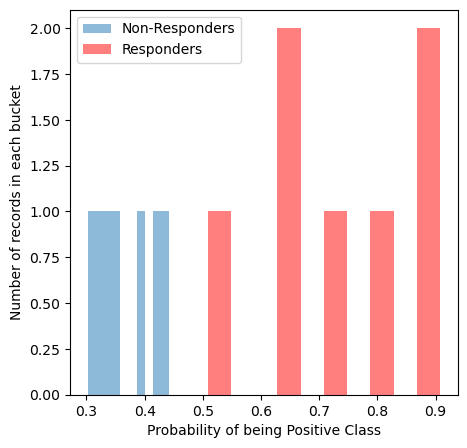

In [27]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [28]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [29]:
df1

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.252086,1.037334,-0.004297,0.032270,-0.014117,0.019787,0.060087,-0.104252,2.403968,0.071395,...,-0.394950,-1.187590,0.907110,-1.107392,-0.322921,0.338147,-0.650807,0.946799,NaN,NaN
1,1.949560,0.208509,-0.239529,-0.235953,-0.014117,-0.210482,0.060087,-0.104252,-1.021326,5.042785,...,-1.151304,0.019664,-0.929615,-0.960551,-1.033955,-2.165956,-1.575279,0.576646,NaN,NaN
2,-0.568050,-0.945937,-0.336543,-0.236893,-0.014117,-0.365302,0.060087,-0.569995,-1.113219,0.071395,...,0.059571,-1.041614,-0.108831,-0.987658,-0.177096,-0.547006,-0.530402,-0.372065,NaN,NaN
3,2.261136,0.739091,-0.360518,-0.237506,-0.515343,0.019787,0.060087,-0.419376,-0.784388,0.071395,...,-0.117330,-0.288185,0.393971,0.389097,-0.269967,-0.828767,0.687513,-0.954890,NaN,NaN
4,1.401232,-0.888240,-0.004297,-0.235376,-0.014117,0.019787,0.060087,-0.346046,-1.035701,-0.091191,...,-1.242534,0.281905,-1.685964,1.353960,-1.984796,-0.663144,-1.073144,-0.223805,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-0.870261,-0.538599,0.042742,-0.126029,-0.206288,0.019787,0.060087,-0.104252,-0.589406,0.071395,...,2.308057,1.119535,1.245847,-0.057174,0.474466,1.542349,1.608172,-0.517307,NaN,NaN
66,-0.360755,0.402967,0.008203,-0.233592,-0.029185,-0.331478,0.060087,-0.104252,-0.177705,0.071395,...,0.105721,0.045525,0.163276,-0.172301,1.364920,0.224841,-0.333241,0.291746,NaN,NaN
67,1.699662,0.922986,-0.004297,-0.131206,-0.014117,0.019787,0.060087,-0.104252,1.237181,0.071395,...,-0.174184,-1.137156,0.134886,-1.008295,-0.261082,0.070419,-0.502206,0.735418,NaN,NaN
68,-0.769558,-0.112271,-0.218785,-0.235689,-0.069432,-0.305302,0.060087,-0.104252,0.464264,0.071395,...,-0.083421,-0.096854,-0.284078,-0.479752,-0.580953,0.348071,-0.015766,0.007402,NaN,NaN


In [30]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(3, 24025)

In [31]:
df1_main.index.values #0 40 41 42

array([42, 43, 45], dtype=int64)

In [32]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 619
Features selected during iteration 1: 595
Features selected during iteration 2: 622
Features selected during iteration 3: 627
Features selected during iteration 4: 617
Features selected during iteration 5: 620
Features selected during iteration 6: 646
Features selected during iteration 7: 622
Features selected during iteration 8: 637
Features selected during iteration 9: 619
Features selected during iteration 10: 644
Features selected during iteration 11: 623
Features selected during iteration 12: 627
Features selected during iteration 13: 627
Features selected during iteration 14: 595
Features selected during iteration 15: 604
Features selected during iteration 16: 622
Features selected during iteration 17: 620
Features selected during iteration 18: 592
Features selected during iteration 19: 606
Features selected during iteration 20: 616
Features selected during iteration 21: 606
Features selected during iteration 22: 607
Features selected dur

In [33]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 618.68


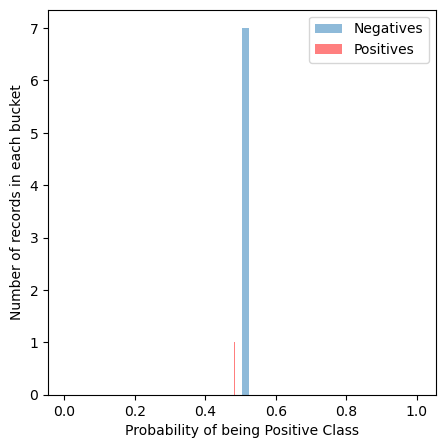

In [34]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [35]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [36]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [37]:
df2_main.index.values #40 41 42

array([], dtype=int64)

In [38]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 32
Features selected during iteration 1: 32
Features selected during iteration 2: 32
Features selected during iteration 3: 32
Features selected during iteration 4: 32
Features selected during iteration 5: 32
Features selected during iteration 6: 32
Features selected during iteration 7: 32
Features selected during iteration 8: 32
Features selected during iteration 9: 32
Features selected during iteration 10: 32
Features selected during iteration 11: 32
Features selected during iteration 12: 32
Features selected during iteration 13: 32
Features selected during iteration 14: 32
Features selected during iteration 15: 32
Features selected during iteration 16: 32
Features selected during iteration 17: 32
Features selected during iteration 18: 32
Features selected during iteration 19: 32
Features selected during iteration 20: 32
Features selected during iteration 21: 32
Features selected during iteration 22: 32
Features selected during iteration 23: 32
Fe

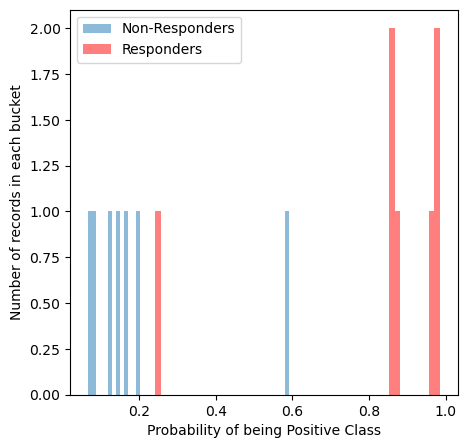

In [39]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [40]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.252086,1.037334,-0.004297,0.032270,-0.014117,0.019787,0.060087,-0.104252,2.403968,0.071395,...,-0.394950,-1.187590,0.907110,-1.107392,-0.322921,0.338147,-0.650807,0.946799,NaN,NaN
1,1.949560,0.208509,-0.239529,-0.235953,-0.014117,-0.210482,0.060087,-0.104252,-1.021326,5.042785,...,-1.151304,0.019664,-0.929615,-0.960551,-1.033955,-2.165956,-1.575279,0.576646,NaN,NaN
2,-0.568050,-0.945937,-0.336543,-0.236893,-0.014117,-0.365302,0.060087,-0.569995,-1.113219,0.071395,...,0.059571,-1.041614,-0.108831,-0.987658,-0.177096,-0.547006,-0.530402,-0.372065,NaN,NaN
3,2.261136,0.739091,-0.360518,-0.237506,-0.515343,0.019787,0.060087,-0.419376,-0.784388,0.071395,...,-0.117330,-0.288185,0.393971,0.389097,-0.269967,-0.828767,0.687513,-0.954890,NaN,NaN
4,1.401232,-0.888240,-0.004297,-0.235376,-0.014117,0.019787,0.060087,-0.346046,-1.035701,-0.091191,...,-1.242534,0.281905,-1.685964,1.353960,-1.984796,-0.663144,-1.073144,-0.223805,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-0.870261,-0.538599,0.042742,-0.126029,-0.206288,0.019787,0.060087,-0.104252,-0.589406,0.071395,...,2.308057,1.119535,1.245847,-0.057174,0.474466,1.542349,1.608172,-0.517307,NaN,NaN
66,-0.360755,0.402967,0.008203,-0.233592,-0.029185,-0.331478,0.060087,-0.104252,-0.177705,0.071395,...,0.105721,0.045525,0.163276,-0.172301,1.364920,0.224841,-0.333241,0.291746,NaN,NaN
67,1.699662,0.922986,-0.004297,-0.131206,-0.014117,0.019787,0.060087,-0.104252,1.237181,0.071395,...,-0.174184,-1.137156,0.134886,-1.008295,-0.261082,0.070419,-0.502206,0.735418,NaN,NaN
68,-0.769558,-0.112271,-0.218785,-0.235689,-0.069432,-0.305302,0.060087,-0.104252,0.464264,0.071395,...,-0.083421,-0.096854,-0.284078,-0.479752,-0.580953,0.348071,-0.015766,0.007402,NaN,NaN


In [41]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
42,0.591537,-0.737468,-0.008250,-0.23043,0.598698,-0.127399,0.060087,4.932882,-0.184314,0.015462,...,-0.946014,0.077703,-1.440134,-0.040575,-2.096860,-1.021575,-1.701823,0.525505,0.854435,1.0
43,-0.864542,-0.950472,0.264801,-0.23494,-0.338503,0.019787,0.060087,-0.104252,-0.896759,0.071395,...,2.308433,0.576402,1.533664,-0.424263,-0.307266,1.898789,1.308358,-0.363661,0.956273,1.0


In [42]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [43]:
cl = set(common_list)
cl

{42, 43, 45}

In [44]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
42,0.591537,-0.737468,-0.008250,-0.230430,0.598698,-0.127399,0.060087,4.932882,-0.184314,0.015462,...,-0.946014,0.077703,-1.440134,-0.040575,-2.096860,-1.021575,-1.701823,0.525505,0.659600,1.0
43,-0.864542,-0.950472,0.264801,-0.234940,-0.338503,0.019787,0.060087,-0.104252,-0.896759,0.071395,...,2.308433,0.576402,1.533664,-0.424263,-0.307266,1.898789,1.308358,-0.363661,0.796267,1.0
45,-0.686714,-1.020888,-0.180217,-0.236664,-0.515417,-0.340597,0.060087,-0.294945,-0.140548,-1.649035,...,1.752439,-0.966908,1.856774,0.217827,0.750810,1.075815,1.539978,1.460293,0.508400,1.0


In [45]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [46]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')